## Landmark Detection

In [1]:
import sys
sys.path.append('./HRNet-Facial-Landmark-Detection')

In [2]:
from lib.models.hrnet import HighResolutionNet
from lib.config import config
from lib.models import get_face_alignment_net
from lib.utils.transforms import crop
import torch
import numpy as np
from PIL import Image
from skimage.transform import resize
from matplotlib import pyplot as plt 
import cv2

In [13]:
config.defrost()
config.merge_from_file("./face_alignment_300w_hrnet_w18.yaml")
config.OUTPUT_DIR = './out'
#config.GPUS = (0 , 1)
config.MODEL.INIT_WEIGHTS = False
config.freeze()
model = get_face_alignment_net(config)
device = torch.device('cpu')
model.to(device)
model = model.cpu()
image_path = './side_crop.png'
state_dict = torch.load("./cpu_model", map_location=device)
model.load_state_dict(torch.load("./cpu_model", map_location=device))

<All keys matched successfully>

In [14]:
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img = np.array(Image.open(image_path).convert('RGB'), dtype=np.float32)
img = resize(img, [256,256])
img = img.astype(np.float32)
img = (img/255.0 - mean) / std
img = img.transpose([2, 0, 1])

In [15]:
output = model(torch.Tensor(img).unsqueeze(dim=0))

In [16]:
output = output.data.cpu()

In [17]:
def get_preds(scores):
    """
    get predictions from score maps in torch Tensor
    return type: torch.LongTensor
    """
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:, :, 0] = (preds[:, :, 0] - 1) % scores.size(3) + 1
    preds[:, :, 1] = torch.floor((preds[:, :, 1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

In [18]:
coords = get_preds(output)
coords = coords.squeeze()
coords = coords.numpy()

In [ ]:
#Eye and temple points
#(0,16)
#(39,42)

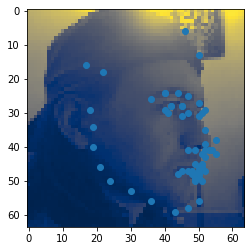

In [20]:
res = cv2.resize(img[2,:,:], dsize=(64, 64), interpolation=cv2.INTER_CUBIC )
plt.imshow(res,cmap="cividis")
plt.scatter(coords[:,0],coords[:,1])

## Paper Segmentation

In [28]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/cameron/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /home/cameron/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


In [51]:
import torchvision.transforms as T
image_path = './page2.png'
img = Image.open(image_path).convert('RGB')
trf = T.Compose([T.Resize([256,256]),
                 #T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [52]:
inp.shape

torch.Size([1, 3, 256, 256])

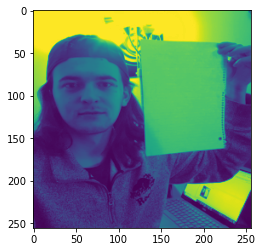

In [75]:
plt.imshow(inp[0][1,:,:])

In [63]:
out = fcn(inp)['out'].cpu().detach()
print (out.shape)

torch.Size([1, 21, 256, 256])


In [64]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

(256, 256)


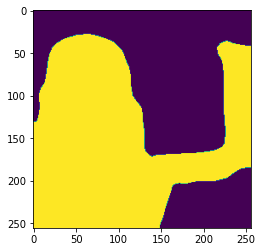

In [65]:
plt.imshow(om)

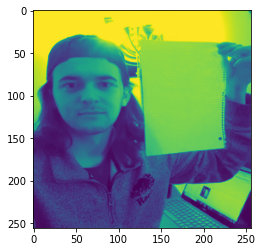

In [57]:
plt.imshow(inp[0][0,:,:])

In [58]:
np.unique(om)

array([ 0, 15])

In [71]:
out[0]

tensor([[[10.1061, 10.1061, 10.1061,  ...,  8.7059,  8.7059,  8.7059],
         [10.1061, 10.1061, 10.1061,  ...,  8.7059,  8.7059,  8.7059],
         [10.1061, 10.1061, 10.1061,  ...,  8.7059,  8.7059,  8.7059],
         ...,
         [ 6.7220,  6.7220,  6.7220,  ...,  6.5408,  6.5408,  6.5408],
         [ 6.7220,  6.7220,  6.7220,  ...,  6.5408,  6.5408,  6.5408],
         [ 6.7220,  6.7220,  6.7220,  ...,  6.5408,  6.5408,  6.5408]],

        [[-1.2492, -1.2492, -1.2492,  ..., -1.5426, -1.5426, -1.5426],
         [-1.2492, -1.2492, -1.2492,  ..., -1.5426, -1.5426, -1.5426],
         [-1.2492, -1.2492, -1.2492,  ..., -1.5426, -1.5426, -1.5426],
         ...,
         [-2.1516, -2.1516, -2.1516,  ..., -2.2865, -2.2865, -2.2865],
         [-2.1516, -2.1516, -2.1516,  ..., -2.2865, -2.2865, -2.2865],
         [-2.1516, -2.1516, -2.1516,  ..., -2.2865, -2.2865, -2.2865]],

        [[-2.0733, -2.0733, -2.0733,  ..., -1.6243, -1.6243, -1.6243],
         [-2.0733, -2.0733, -2.0733,  ..., -1

In [13]:
#Used for converting dict to cpu version we dont need this cell 
from collections import OrderedDict
state_dict = torch.load("./cpu_model")
new_state_dict = OrderedDict()

for key, value in state_dict.items():
    new_key = key.replace('module.','')
    new_state_dict[new_key] = value

torch.save(new_state_dict, './cpu_model')